In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

from summer2 import CompartmentalModel
from summer2.parameters import Parameter, DerivedOutput

In [2]:
def build_demog_model(
    config: dict,
) -> CompartmentalModel:
    
    # Model characteristics
    compartments = (
        "Susceptible", 
        "Pre-infectious", 
        "Infectious", 
        "Immune"
    )
    model = CompartmentalModel(
        times=(0., config["end_time"]),
        compartments=compartments,
        infectious_compartments=["Infectious"],
    )
    model.set_initial_population(
        distribution={
            "Susceptible": config["total_population"] - config["infectious_seed"],
            "Infectious": config["infectious_seed"],
        }
    )
    
    # Transitions
    infectious_period = Parameter("infectious_period")
    model.add_infection_frequency_flow(
        name="infection", 
        contact_rate=Parameter("r0") / infectious_period,
        source="Susceptible", 
        dest="Pre-infectious"
    )
    model.add_transition_flow(
        name="progression", 
        fractional_rate=1. / Parameter("latent_period"),
        source="Pre-infectious", 
        dest="Infectious"
    )
    model.add_transition_flow(
        name="recovery", 
        fractional_rate=1. / infectious_period,
        source="Infectious", 
        dest="Immune",
    )
    model.add_replacement_birth_flow(
        "births",
        "Susceptible",
    )
    model.add_universal_death_flows(
        "universal_death",
        death_rate=1. / Parameter("life_expectancy") / 365.,
    )
    
    # Outputs
    model.request_output_for_flow(
        name="incidence", 
        flow_name="progression",
    )
    
    return model

In [3]:
model_config = {
    "end_time": 25550.,
    "total_population": 1e5,
    "infectious_seed": 1.,
}

parameters = {
    "latent_period": 8.,
    "infectious_period": 7.,
    "r0": 13.,
    "life_expectancy": 70.,
}

In [4]:
seir_demog_model = build_demog_model(model_config)
seir_demog_model.run(parameters=parameters, solver="euler")

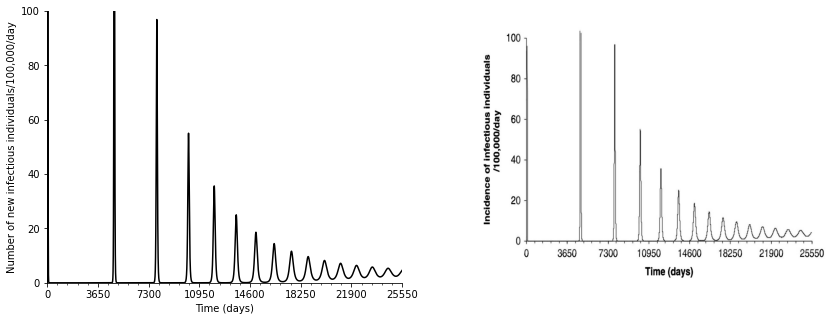

In [5]:
fig, (left_ax, right_ax) = plt.subplots(1, 2, figsize=(14, 5))

left_ax.plot(
    seir_demog_model.times, 
    seir_demog_model.get_derived_outputs_df()["incidence"], 
    color="k",
)
left_ax.set_xlim(0., 25550.)
left_ax.set_xticks(range(0, 29200, 3650))
left_ax.xaxis.set_minor_locator(AutoMinorLocator(5))
left_ax.set_xlabel("Time (days)")
left_ax.set_ylim(0, 100.)
left_ax.set_ylabel("Number of new infectious individuals/100,000/day")
left_ax.spines.top.set_visible(False)
left_ax.spines.right.set_visible(False)

image = plt.imread("./figures/fig_4_17.jpg")
right_ax.axis("off")
right_ax.imshow(image, aspect="auto");